In [1]:
import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import scipy.stats as stats
import utils
import geopandas
import cartopy.crs as ccrs

In [ ]:
df_link = pd.read_csv('https://data.cityofnewyork.us/resource/i4gi-tjb9.csv?$query=SELECT%20DISTINCT%20LINK_POINTS,LINK_ID,BOROUGH,LINK_NAME')
df_link.to_csv('linkIds.csv')

In [2]:
year = 2019
path = f'../nyc_speed_data/*{year}.csv'
boro_sel = ['Manhattan','Staten Island','Queens','Bronx','Brooklyn']
window = '2H'
freq = '15min'

In [3]:
# df_link = pd.read_csv('https://data.cityofnewyork.us/resource/i4gi-tjb9.csv?$query=SELECT%20DISTINCT%20LINK_POINTS,LINK_ID,BOROUGH,LINK_NAME')
# df_link.to_csv('linkIds.csv')

In [4]:
df_link = pd.read_csv('linkIds.csv')
df_link.head()

,Unnamed: 0,link_points,link_id,borough
0,0,"40.604181,-74.0523 40.60376,-74.05356 40.60344...",4616204,Staten island
1,1,"40.772251,-73.919891 40.77391,-73.9222 40.7747...",4456478,Queens
2,2,"40.56058,-74.199581 40.55926,-74.20113 40.5584...",4616202,Staten Island
3,3,"40.6332305,-74.016151 40.63391,-74.01613 40.63...",4616319,Brooklyn
4,4,"40.608031,-74.13212 40.60759,-74.1409",4616194,Staten Island


# Clean Traffic Data

In [5]:
fname = '../nybb_20c/nybb.shp'
df = geopandas.read_file(fname)

# Define the CartoPy CRS object.
crs = ccrs.epsg(2263)

# This can be converted into a `proj4` string/dict compatible with GeoPandas
crs_proj4 = crs.proj4_init
df_ae = df.to_crs(crs_proj4)

### Manhattan only

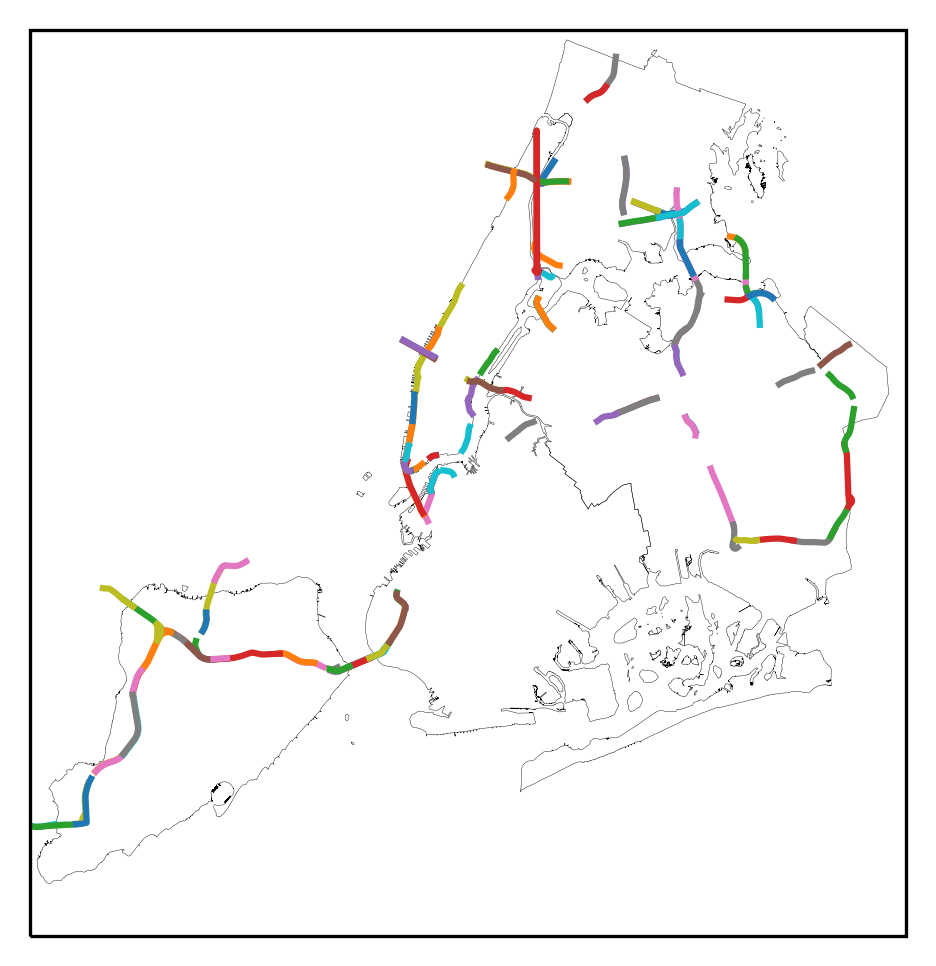

In [6]:
fig, ax = plt.subplots(subplot_kw={'projection': crs})
fig.dpi=300
ax.add_geometries(df_ae['geometry'], crs=crs,facecolor='none',edgecolor='k',lw=0.1)
ax.set_extent([-74.26, -73.69, 40, 40.92])

for link_points,ind,boro in zip(df_link['link_points'],df_link.index,df_link['borough']):
    pos = link_points.split(' ')
    pos = [elem for elem in pos if (len(elem) < 25) & (len(elem) > 16)]
    pos_split = [item.split(',') for item in pos]
    pos_array = np.array(pos_split,dtype='float')
    if ~pos_array[pos_array[:,1] < -74.3].any() & (boro in boro_sel):
        plt.plot(pos_array[:,1],pos_array[:,0],transform=ccrs.PlateCarree())

In [7]:
link_ids = df_link[df_link['borough'].isin(boro_sel)]['link_id'].unique()

In [8]:
df = utils.load_csv(path)

 42%|████▏     | 5/12 [00:04<00:06,  1.03it/s]/home/smr1020/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3263: DtypeWarning: Columns (0,1,2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
100%|██████████| 12/12 [00:17<00:00,  1.43s/it]


In [9]:
df = df[df['linkId'].isin(link_ids)]

In [10]:
df = df.dropna()
df['DataAsOf'] = pd.to_datetime(df['DataAsOf'])

In [11]:
mean = df[['Speed','linkId']].groupby('linkId').mean()
gt_20 = mean[mean['Speed']>20].index.astype(int)

In [12]:
mean = mean/mean.max()

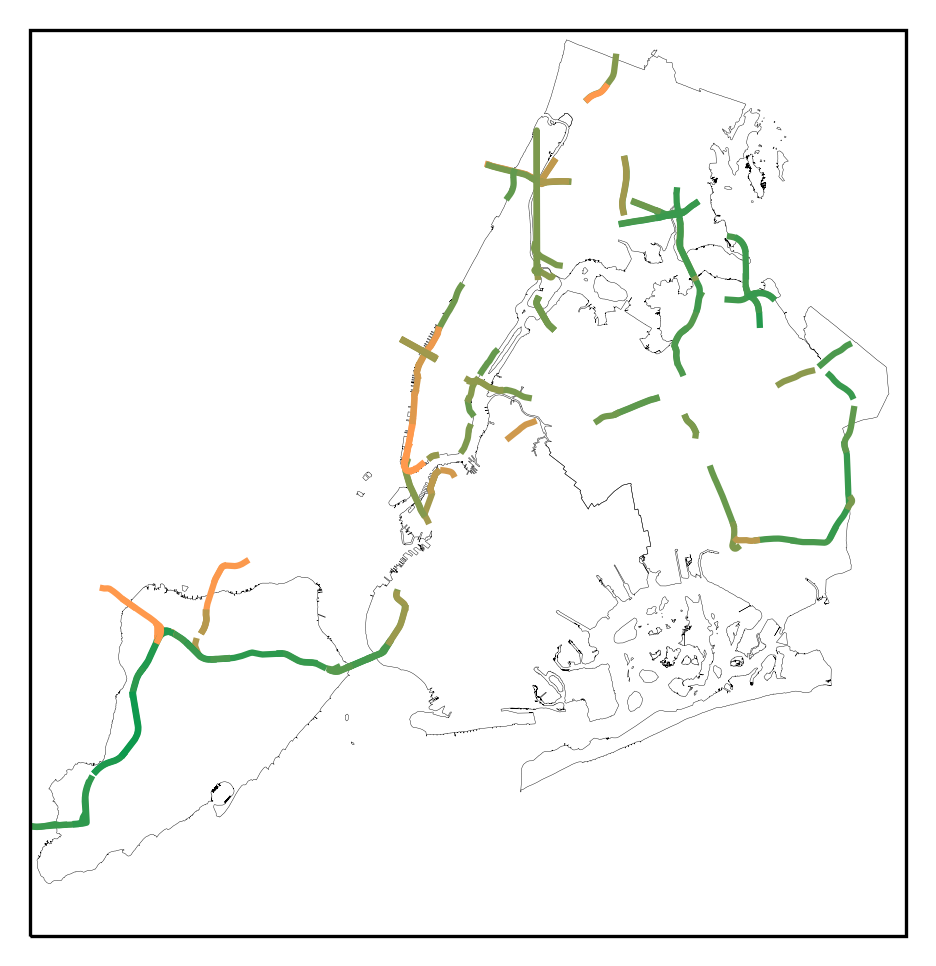

In [13]:
fig, ax = plt.subplots(subplot_kw={'projection': crs})
fig.dpi=300
ax.add_geometries(df_ae['geometry'], crs=crs,facecolor='none',edgecolor='k',lw=0.1)
ax.set_extent([-74.26, -73.69, 40, 40.92])

for link_points,ind,boro in zip(df_link['link_points'],df_link.index,df_link['borough']):
    pos = link_points.split(' ')
    pos = [elem for elem in pos if (len(elem) < 25) & (len(elem) > 16)]
    pos_split = [item.split(',') for item in pos]
    pos_array = np.array(pos_split,dtype='float')
    if ~pos_array[pos_array[:,1] < -74.3].any() & (boro in boro_sel):
        c = mean[mean.index.astype(int) == df_link.link_id.loc[ind].astype(int)]
        if len(c) == 0:
            c = 0
        else:
            c = c.values[0][0]
        plt.plot(pos_array[:,1],pos_array[:,0],transform=ccrs.PlateCarree(),c=((1-1*c),0.6,0.3))

In [14]:
df = df[df['linkId'].isin(gt_20)]

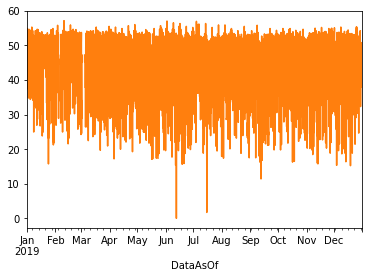

In [15]:
df_list = []
for group in df.groupby('linkId'):
    df_tem = group[1].set_index('DataAsOf')
    df_i = df_tem.rename(columns = {'Speed':df_tem['linkId'][0]})[df_tem['linkId'][0]]
    df_i = df_i.resample(freq).mean()

    df_list.append(df_i)

df_rs = pd.concat(df_list, axis=1, ignore_index=False)
df_rs.median(axis=1).plot(c='tab:orange',xlim=(f'{year}-01-01',f'{year}-12-31'))

### Remove times where we have less than 75% of sensors working 
If too many sensors are down, the median response won't represent the whole city

In [16]:
sensor_outage = df_rs.isna().sum(axis=1)
tol = 153-(153*0.75)

cond_keep = sensor_outage<tol
cond_toss = sensor_outage>tol

speed_ts = df_rs.median(axis=1)

speed_ts[cond_toss] = np.nan

### Visualize removal of times

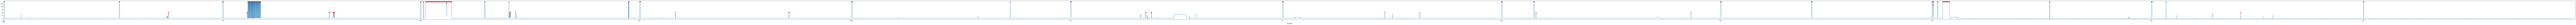

In [17]:
plt.figure(figsize = (400,3))
df_rs.isna().sum(axis=1).plot(xlim=(f'{year}-01-01',f'{year}-12-31'))
plt.scatter(df_rs.isna().sum(axis=1)[cond_toss].index,
            df_rs.isna().sum(axis=1)[cond_toss],c='r',zorder=20)

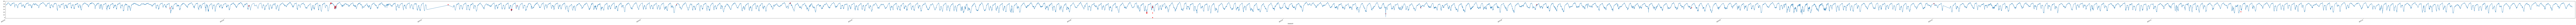

In [18]:
plt.figure(figsize = (400,3))
df_rs.median(axis=1)[cond_keep].plot(xlim=(f'{year}-01-01',f'{year}-12-31'))

plt.scatter(df_rs.median(axis=1)[cond_toss].index,
            df_rs.median(axis=1)[cond_toss],c='r')

### A normal day

In [19]:
speed_ts = speed_ts.resample(freq).mean()

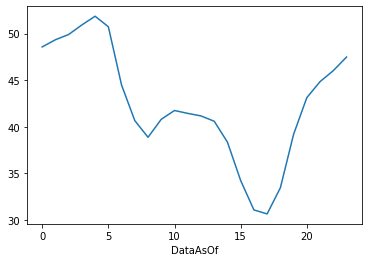

In [20]:
speed_ts.groupby(df_rs.index.hour).mean().plot()

# Clean Weather Data

download weather data via api request

In [21]:
baseurl='https://mesonet.agron.iastate.edu/cgi-bin/request/asos.py?'

request = f'station=NYC\
&data=tmpf&data=dwpf&data=p01i&data=tempf&data=sped\
&year1={year}&month1=1&day1=1&year2={year}&month2=12&day2=31&tz=Etc%2FUTC\
&format=onlycomma&latlon=no&missing=M&trace=T&direct=no&report_type=1&report_type=2'

df_weather = pd.read_csv(f'{baseurl}{request}',na_values=['M'])
df_weather.isna().sum()

station       0
valid         0
tmpf        150
dwpf        152
p01i          0
sped       2715
dtype: int64

In [22]:
# small amounts of precip are marked at T (trace)
df_weather['p01i'][df_weather['p01i'] == 'T'] = 0.001
df_weather['p01i'] = df_weather['p01i'].astype(float)

# set datetime index and make sure only these columns are in the data ['time','tmpf','dwpf','p01i']
df_weather['time'] = pd.to_datetime(df_weather['valid'])
df_weather = df_weather[['time','p01i','tmpf']]
df_weather['time'] = df_weather['time'] - pd.Timedelta('30min')
df_weather = df_weather.set_index('time')

#get weather "forecast" by shifting time index
df_weather_pred = df_weather
df_weather_pred = df_weather_pred.set_index(df_weather.index - pd.Timedelta(window))
df_weather_pred = df_weather_pred.rename({'p01i': 'p01i_pred', 'tmpf': 'tmpf_pred'}, axis='columns')

#drop na values
df_weather = df_weather.dropna()
df_weather_pred = df_weather_pred.dropna()


<ipython-input-22-592fbd9b052e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_weather['p01i'][df_weather['p01i'] == 'T'] = 0.001


In [23]:
df_weather = df_weather.resample(freq).pad()
df_weather_pred = df_weather_pred.resample(freq).pad()

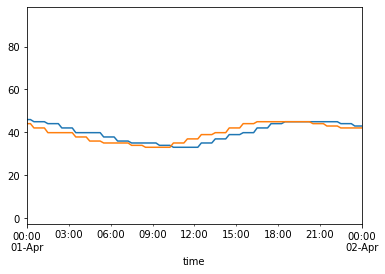

In [24]:
df_weather['tmpf'].plot(xlim=(f'{year}-04-01',f'{year}-04-02'))
df_weather_pred['tmpf_pred'].plot(xlim=(f'{year}-04-01',f'{year}-04-02'))

In [25]:
df_weather['tmpf_pred'] = df_weather_pred['tmpf_pred']
df_weather['p01i_pred'] = df_weather_pred['p01i_pred']

# Merge Weather and Traffic Data

In [26]:
df_merge = df_weather
df_merge['speed'] = speed_ts
df_merge = df_merge[df_merge.index.isin(speed_ts.index)]

In [27]:
dhour = (df_merge.index.hour.values+df_merge.index.minute.values/60)

# normalize using sin
df_merge['weekday'] = (df_merge.index.dayofweek < 5).astype(int)
df_merge['hour'] = np.sin((dhour/24)*2*np.pi)

<ipython-input-27-1ec2291faea2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['weekday'] = (df_merge.index.dayofweek < 5).astype(int)
<ipython-input-27-1ec2291faea2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merge['hour'] = np.sin((dhour/24)*2*np.pi)


In [28]:
cond = df_merge['speed'].isna()

In [29]:
df_merge = df_merge.interpolate(method='linear',limit=4)

In [30]:
df_merge['gaps'] = df_merge['speed'].isna().rolling(4).sum()
df_merge['gaps'] = (df_merge['gaps'] > 0).astype(int)

In [31]:
def build_am_pm_range(day,freq=freq,am_start = 4,am_end = 12,pm_start = 12,pm_end = 20):
    
    am_start = pd.to_datetime(day.index.date[0]) + pd.Timedelta(f'{am_start}H')
    am_end = pd.to_datetime(day.index.date[0]) + pd.Timedelta(f'{am_end}H')
    
    pm_start = pd.to_datetime(day.index.date[0]) + pd.Timedelta(f'{pm_start}H')
    pm_end = pd.to_datetime(day.index.date[0]) + pd.Timedelta(f'{pm_end}H')
    
    am_range = pd.date_range(start=am_start,end=am_end, freq=freq)
    pm_range = pd.date_range(start=pm_start,end=pm_end, freq=freq)
    
    return am_range,pm_range

In [32]:
df_copy = df_merge
count = 0
morning_list = []
afternoon_list = []


for group in df_copy.groupby(df_copy.index.date):
    
    day = group[1]
    day['speed_diff'] = day['speed'].diff()
    am_range,pm_range = build_am_pm_range(day)
    
    morning = day[day.index.isin(am_range)]
    afternoon = day[day.index.isin(pm_range)]
    
    if (len(am_range) == len(morning)) & (morning['gaps'].max() < 1):
        morning_list.append(morning)
    if (len(pm_range) == len(afternoon)) & (afternoon['gaps'].max() < 1):
        afternoon_list.append(afternoon)

<ipython-input-32-6ae52d3298dc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day['speed_diff'] = day['speed'].diff()


In [33]:
len(morning_list)

354

In [34]:
len(afternoon_list)

353

In [35]:
morning_df = pd.concat(morning_list, axis=0, ignore_index=False)
afternoon_df = pd.concat(afternoon_list, axis=0, ignore_index=False)

morning_df.to_csv(f'morning_df_{year}.csv')
afternoon_df.to_csv(f'afternoon_df_{year}.csv')

In [36]:
year

2019